In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using Printf
using ControlSystems

In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [4]:
#Quadrotor parameters
m = 0.027
J = [16.6e-6 0.83e-6 0.72e-6;
     0.83e-6 16.6e-6 1.8e-6;
     0.72e-6 1.8e-6 29.3e-6];
# J = Array(diagm([1.4194e-05, 1.4089e-05, 2.9741e-05]))
g = 9.81

h = 1/50 #500 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12
Nu = 4     # number of controls
Tfinal = 3.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [5]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[0; 0; u[1]] - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + u[2:4])
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [6]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [7]:
#Initial Conditions
# uhover = (m*g/4)*ones(4)
uhover = [m*g; 0; 0; 0]
r0 = [0.0; 0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [8]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [9]:
# Cost weights/Bryson's rules
max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1]
max_thrust = 60*1e-3*9.81/2
max_torque_x = max_thrust*arm/2
max_torque_z = thrustToTorque*max_thrust/2
max_dev_u = [max_thrust; max_torque_x; max_torque_x; max_torque_z]/6
# Q = Array(diagm([10, 10, 10,  1, 1, 0.1,  1, 1, 1,  1, 1, 0.1]));
Q = Array(diagm(1 ./(max_dev_x.^2)))
# R = Array(0.2*I(Nu));
R = Array(diagm(1 ./(max_dev_u.^2)))
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

4×12 Matrix{Float64}:
 -1.17179e-11   1.31239e-10   0.803438     …  -5.08223e-13  1.25698e-12
  7.30107e-5   -0.0015435     2.11553e-13      4.14629e-5   1.54078e-5
  0.00153822   -7.30934e-5   -4.01025e-13      0.000868381  4.02096e-5
  9.5998e-5    -3.8292e-5    -1.22622e-13      5.84337e-5   0.000923724

In [11]:
R

4×4 Matrix{Float64}:
 415.644  0.0        0.0        0.0
   0.0    1.57143e6  0.0        0.0
   0.0    0.0        1.57143e6  0.0
   0.0    0.0        0.0        4.67333e7

In [226]:
# Saved
max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1]
max_thrust = 60*1e-3*9.81/2
thrustToTorque = 0.005964552
arm = 0.046/sqrt(2)
max_torque_x = max_thrust*arm/2
max_torque_z = thrustToTorque*max_thrust/2
max_dev_u = [max_thrust; max_torque_x; max_torque_x; max_torque_z]/6
# Q = Array(diagm([10, 10, 10,  1, 1, 0.1,  1, 1, 1,  1, 1, 0.1]));
Q = Array(diagm(1 ./(max_dev_x.^2)))
# R = Array(0.2*I(Nu));
R = Array(diagm(1 ./(max_dev_u.^2)))
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

4×12 Matrix{Float64}:
 -1.17179e-11   1.31239e-10   0.803438     …  -5.08223e-13  1.25698e-12
  7.30107e-5   -0.0015435     2.11553e-13      4.14629e-5   1.54078e-5
  0.00153822   -7.30934e-5   -4.01025e-13      0.000868381  4.02096e-5
  9.5998e-5    -3.8292e-5    -1.22622e-13      5.84337e-5   0.000923724

In [160]:
static float K[NU][NXt] = {
  {0.000000f,0.000000f,0.689184f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.715675f,0.000000f,0.000000f,0.000000f},
  {0.000039f,-0.000787f,0.000000f,0.008869f,0.000443f,0.000036f,0.000058f,-0.001153f,0.000000f,0.000874f,0.000044f,0.000036f},
  {0.000787f,-0.000039f,0.000000f,0.000443f,0.008869f,0.000089f,0.001153f,-0.000058f,0.000000f,0.000044f,0.000874f,0.000090f},
  {0.000085f,-0.000034f,0.000000f,0.000383f,0.000958f,0.001455f,0.000125f,-0.000050f,0.000000f,0.000038f,0.000094f,0.001469f},
};

now
static float K[NU][NXt] = {
  {0.000000f,0.000000f,0.689184f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.715675f,0.000000f,0.000000f,0.000000f},
  {0.000039f,-0.000787f,0.000000f,0.008870f,0.000443f,0.000036f,0.000058f,-0.001153f,0.000000f,0.000874f,0.000044f,0.000036f},
  {0.000787f,-0.000039f,0.000000f,0.000443f,0.008870f,0.000090f,0.001153f,-0.000058f,0.000000f,0.000044f,0.000874f,0.000090f},
  {0.000085f,-0.000034f,0.000000f,0.000385f,0.000962f,0.001458f,0.000125f,-0.000050f,0.000000f,0.000038f,0.000095f,0.001472f},
};


ErrorException: syntax: extra token "float" after end of expression

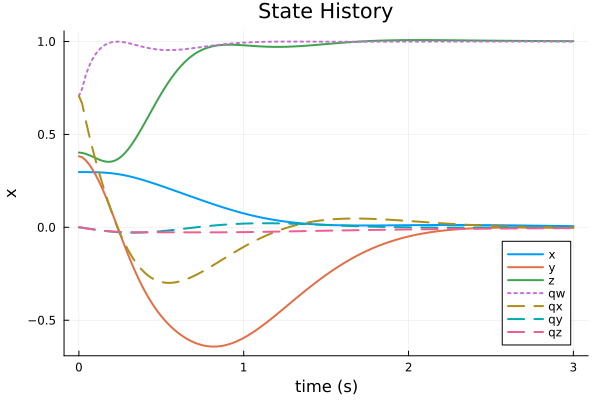

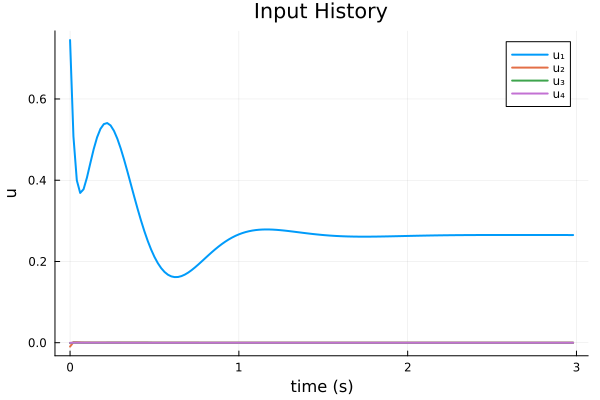

In [257]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    u = uhover - K*Δx̃
end
#Simulation
Random.seed!(1);
uhist = zeros(Nu,Nt-1)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq([1; 0; 0]); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz" ],
linestyle=[:solid :solid :solid :dot :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],uhist',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [266]:
xhist[1:3,Nt] - r0

3-element Vector{Float64}:
  0.006175064725030137
 -0.0027869419509604634
  0.0016726551969523662

In [ ]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8703))

In [ ]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [ ]:
X1 = [SVector{13}(x) for x in eachcol(xhist)];
visualize!(vis, model, thist[end], X1)

In [259]:
scale = 65535
display(K)
# C Language
@printf("FOR C:\n");
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str * "f"
    if j < 12
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)

@printf("\n\nFOR PYTHON:\n");
# Python Language
str = "K = np.array([\n"
for i = 1:4
  str = str * "  ["
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str 
    if j < 12
      str = str * ","
    end
  end
  str = str * "],\n"
end
str = str * "])"
@printf("%s",str)


4×12 Matrix{Float64}:
 6.89968e-11  -2.13952e-9   0.803438     …  8.53574e-12  5.84338e-13
 7.6206e-5    -0.00155647  -1.34615e-10     4.30621e-5   2.67361e-5
 0.00155399   -7.6243e-5   -1.86392e-9      0.000876278  6.76629e-5
 0.00013621   -5.44331e-5  -1.56906e-10     7.87567e-5   0.00122938

FOR C:
static float K[NU][NXt] = {
  {0.000005f,-0.000140f,52653.331642f,0.000451f,0.000116f,0.000004f,0.000011f,-0.000092f,29655.145947f,0.000002f,0.000001f,0.000000f},
  {4.994163f,-102.003187f,-0.000009f,664.757240f,32.583295f,3.411040f,4.777267f,-97.535743f,-0.000001f,57.508688f,2.822074f,1.752151f},
  {101.840667f,-4.996583f,-0.000122f,32.599051f,663.753591f,8.635494f,97.383191f,-4.779672f,-0.000007f,2.823372f,57.426884f,4.434289f},
  {8.926535f,-3.567274f,-0.000010f,23.538639f,58.898015f,157.340335f,8.573598f,-3.426313f,-0.000001f,2.062858f,5.161323f,80.567476f},
};

FOR PYTHON:
K = np.array([
  [0.000005,-0.000140,52653.331642,0.000451,0.000116,0.000004,0.000011,-0.000092,29655.145947,0.000002,0.000001,0.000000],
  [4.994163,-102.003187,-0.000009,664.757240,32.583295,3.411040,4.777267,-97.535743,-0.000001,57.508688,2.822074,1.752151],
  [101.840667,-4.996583,-0.000122,32.599051,663.753591,8.635494,97.383191,-4.779672,-0.000007,2.823372,57.426884,4.434289],
  [8.926535,-3.567274,